# Classification analysis with MLP

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# Plot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors as pltcolors
%matplotlib inline
plt.rcParams["font.size"] = 16

import sys
sys.path.append("../../scripts")
from noiseReductionMethodology import preprocessing, Raman_model
from classification import classification_method
from analysis_pclda import LDA_model
from predictFunc import calcPrediction
from util import returnValues

In [2]:
nameList = ["PCA", "NRM"]
colorList = ["gray", "#B51700"]
numList = np.arange(12, 57, 6)
nListStr = np.hstack(["All", numList[::-1]]).astype(str)

condition_color = np.hstack([
    [pltcolors.to_hex(plt.get_cmap("autumn", 4)(i + 1)) for i in range(2)],
    [pltcolors.to_hex("C8")],
    [pltcolors.to_hex(plt.get_cmap("summer", 3)(1 - i)) for i in range(2)],
    [pltcolors.to_hex(plt.get_cmap("Blues", 3)(i + 1)) for i in range(1)],
    [pltcolors.to_hex(a) for a in ["royalblue", "blueviolet", "violet", "sienna"]],
])

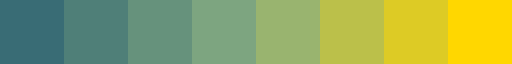

In [3]:
cm_nList = pltcolors.LinearSegmentedColormap.from_list('', ["#396C75", "#89AF82", "gold"], len(numList))
cm_nList

## Classification analysis

### All samples

In [4]:
RAMAN = pd.read_csv("../../data/RAMAN_FINGERPRINT.csv")
RAMAN_PROCESSED = preprocessing(RAMAN)
GROUP = [RAMAN_PROCESSED[RAMAN_PROCESSED["label"] == i].reset_index(drop=True) for i in range(RAMAN_PROCESSED["label"].max() + 1)]

In [5]:
cutRanges = np.arange(60, 100, 0.5)
cutRangesStr = [f"{a:.0f}" if a % 1 == 0 else f"{a:.1f}".replace(".", "")
                for a in cutRanges]

In [6]:
accList_pca = []
accList_nrm = []

for i in cutRanges:
    raman_model_ = Raman_model(RAMAN_PROCESSED, cutMode="percent_fixedDim", cutRange=i)
    raman_model_.calcTransformation()

    accList_pca.append(classification_method(raman_model_.RAMAN_PCA, method="MLP", isPrint=False))
    accList_nrm.append(classification_method(raman_model_.RAMAN_NRM, method="MLP", isPrint=False))
    
    print(".", end="")
print("")

................................................................................


In [7]:
RESULTS = pd.DataFrame(np.vstack([np.mean(accList_pca, axis=1), np.mean(accList_nrm, axis=1)]).T,
                       columns=["PCA", "NRM"],
                       index=[f"{a:.1f}%" for a in cutRanges])

RESULTS.to_csv("../../results/classification/MLP/ACCLIST_ALLDATA_MLP_PERCENT_fixedDim.csv", index=True)

### Datasets with various sample sizes

Before running the subsequent analysis in this notebook, please execute the following command-line scripts to perform MLP classification across various sample sizes:

```bash
python classification.py -o ../results/classification/MLP --mode PCA --classificationMethod MLP --cutMode percent --cutRange_start 60 --cutRange_end 99.5 --cutRange_step 0.5

python classification.py -o ../results/classification/MLP --mode NRM --classificationMethod MLP --cutMode percent_fixedDim --cutRange_start 60 --cutRange_end 99.5 --cutRange_step 0.5
```

The results will be stored in the `results/classification/MLP/` directory and will be loaded later in this notebook.

## [Fig. 6d] Effects of threshold on PCA-based classification 

In [17]:
RESULTS = pd.read_csv("../../results/classification/MLP/ACCLIST_ALLDATA_MLP_PERCENT_fixedDim.csv", index_col=0)
RESULTS.head()

,PCA,NRM
60.0%,23.145833,23.354167
60.5%,23.322917,23.385417
61.0%,23.406250,23.458333
61.5%,23.302083,23.562500
62.0%,23.375000,23.364583


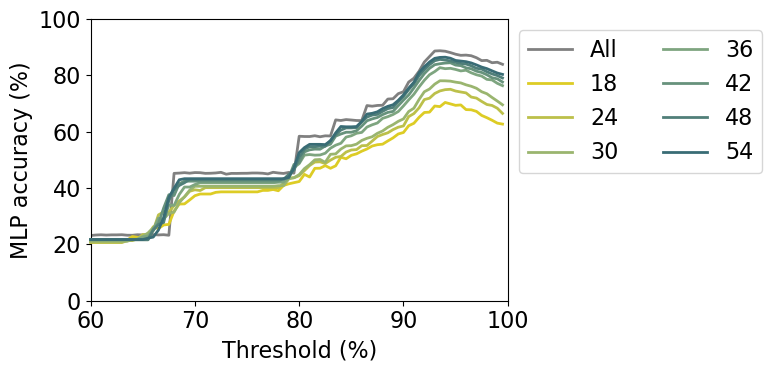

In [18]:
fig = plt.figure(figsize=(8, 4))


plt.plot(cutRanges, RESULTS["PCA"].values, color="gray", linewidth=2, label="All")

acc_pca_data = np.array([np.vstack([pd.read_csv(f"../../results/classification/MLP/ACCLIST_NUMEFFECTS_PCA_cutPercent{a}_loop10.csv").values,
                                    pd.read_csv(f"../../results/classification/MLP/ACCLIST_NUMEFFECTS_PCA_cutPercent{a}_loop40_seed1.csv").values])
                         for a in cutRangesStr])


for i, num in enumerate(numList):
    if i == 0:
        continue
    color = cm_nList(len(numList) - i - 1)
    mean = np.mean(acc_pca_data[:, :, i], axis=1)
    std = np.std(acc_pca_data[:, :, i], axis=1)
    plt.plot(cutRanges, mean, color=color, linewidth=2, clip_on=False, zorder=10, label=num)
    
plt.xticks(np.arange(60, 110, 10))
plt.xlim(60, 100)
plt.yticks(np.arange(0, 101, 20))
plt.ylim(0, 100)
plt.xlabel("Threshold (%)")
plt.ylabel("MLP accuracy (%)")

plt.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## [Fig. 6b] Effects of NRM on classification accuracy

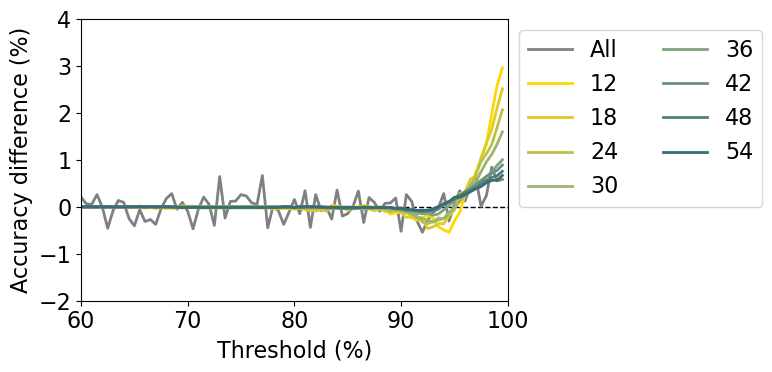

In [19]:
fig = plt.figure(figsize=(8, 4))

plt.plot(cutRanges, RESULTS["NRM"].values - RESULTS["PCA"].values,
         color="gray", linewidth=2, label="All")

acc_pca_data = np.array([np.vstack([pd.read_csv(f"../../results/classification/MLP/ACCLIST_NUMEFFECTS_PCA_cutPercent{a}_loop10.csv").values,
                                    pd.read_csv(f"../../results/classification/MLP/ACCLIST_NUMEFFECTS_PCA_cutPercent{a}_loop40_seed1.csv").values])
                         for a in cutRangesStr])

acc_nrm_data = np.array([np.vstack([pd.read_csv(f"../../results/classification/MLP/ACCLIST_NUMEFFECTS_NRM_cutPercent_fixedDim{a}_loop10.csv").values,
                                    pd.read_csv(f"../../results/classification/MLP/ACCLIST_NUMEFFECTS_NRM_cutPercent_fixedDim{a}_loop40_seed1.csv").values])
                         for a in cutRangesStr])

for i, num in enumerate(numList):
    mean = np.mean(acc_nrm_data[:, :, i] - acc_pca_data[:, :, i], axis=1)
    plt.plot(cutRanges, mean, color=cm_nList(len(numList) - 1 - i), linewidth=2, label=num)
        
plt.hlines(0, 0, 120, color="k", linewidth=1, linestyle="dashed", zorder=0)
plt.xticks(np.arange(60, 101, 10))
plt.xlim(60, 100)
plt.yticks(np.arange(-2, 5, 1))
plt.ylim(-2, 4)
plt.xlabel(f"Threshold (%)")
plt.ylabel("Accuracy difference (%)")
plt.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## [Fig. 6c] Classification accuracy at the threshold optimized for transcriptomic profile estimation

In [23]:
SUMMARY_PERCENTAGE_fixedDim = pd.DataFrame([])

for n in nListStr:
    if n == "All":
        OUT= pd.read_csv("../../results/SUMMARY_PERCENT_fixedDim_SPOMBE.csv", index_col=0).sort_values(["PRESS_PCA"]).reset_index(drop=False).loc[[0], :]

    else:
        OUT = pd.read_csv(f"../../results/SUMMARY_PERCENT_fixedDim_SPOMBE_dataSize{n}.csv", index_col=0).sort_values(["PRESS_PCA"]).reset_index(drop=False).loc[[0], :]
    
    OUT["sampleSize"] = n
    SUMMARY_PERCENTAGE_fixedDim = pd.concat([SUMMARY_PERCENTAGE_fixedDim, OUT], axis=0, ignore_index=True)
    
SUMMARY_PERCENTAGE_fixedDim["percent_PCA"] = [float(a.replace("%", "")) for a in SUMMARY_PERCENTAGE_fixedDim["index"].values]
SUMMARY_PERCENTAGE_fixedDim.head()

,index,dim_PCA,percent_NRM,PRESS_PCA,PRESS_NRM,PRESS_diff,PRESS_PCA_c1,PRESS_PCA_c2,PRESS_PCA_c3,PRESS_PCA_c4,...,sampleSize,dim_PCA_std,percent_NRM_std,PRESS_PCA_std,PRESS_NRM_std,PRESS_diff_std,PRESS_pVal,cosine_diff_std,cosine_pVal,percent_PCA
0,98.0%,108.00,98.269430,1.435394e+12,1.432007e+12,-3.386932e+09,2.030976e+10,2.566407e+10,7.113794e+11,1.897653e+11,...,All,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0
1,98.5%,126.42,98.714899,1.462947e+12,1.459305e+12,-3.642631e+09,2.038447e+10,2.122209e+10,7.273618e+11,1.965846e+11,...,54,0.929301,0.005446,6.931362e+10,7.017646e+10,1.859572e+09,5.486894e-17,0.000078,9.964477e-11,98.5
2,98.5%,122.59,98.749078,1.458136e+12,1.454005e+12,-4.130623e+09,2.045627e+10,2.110101e+10,7.230088e+11,1.982276e+11,...,48,1.241733,0.006211,8.977015e+10,9.136614e+10,5.513355e+09,1.043665e-15,0.000249,8.214827e-06,98.5
3,98.5%,117.94,98.793087,1.460504e+12,1.457276e+12,-3.228314e+09,2.100351e+10,2.089207e+10,7.243926e+11,2.001424e+11,...,42,1.508774,0.005816,9.869275e+10,1.007011e+11,4.726976e+09,3.883375e-11,0.000236,3.321214e-03,98.5
4,98.5%,112.02,98.854181,1.476064e+12,1.471955e+12,-4.108903e+09,2.121164e+10,2.104084e+10,7.330526e+11,2.039690e+11,...,36,1.838369,0.006500,1.243548e+11,1.273407e+11,4.433664e+09,7.794993e-12,0.000166,3.874622e-03,98.5


In [24]:
accList_PCA_SVMlinear = []
accList_NRM_SVMlinear = []
accList_pval = []

for per, n in SUMMARY_PERCENTAGE_fixedDim.loc[:, ["index", "sampleSize"]].values:
    if n == "All":
        OUT = pd.read_csv("../../results/classification/MLP/ACCLIST_ALLDATA_MLP_PERCENT_fixedDim.csv", index_col=0)
        accList_PCA_SVMlinear.append(np.array([OUT.loc[per].values[0]]))
        accList_NRM_SVMlinear.append(np.array([OUT.loc[per].values[1]]))
        accList_pval.append(np.nan)
    else:
        per = float(per.replace("%", ""))
        if per % 1 == 0:
            per = str(int(per))
        else:
            per = f"{per:.1f}".replace(".", "")
            
        pca = np.hstack([pd.read_csv(f"../../results/classification/MLP/ACCLIST_NUMEFFECTS_PCA_cutPercent{per}_loop10.csv")[f"n={n}"].values,
                         pd.read_csv(f"../../results/classification/MLP/ACCLIST_NUMEFFECTS_PCA_cutPercent{per}_loop40_seed1.csv")[f"n={n}"].values])
        nrm = np.hstack([pd.read_csv(f"../../results/classification/MLP/ACCLIST_NUMEFFECTS_NRM_cutPercent_fixedDim{per}_loop10.csv")[f"n={n}"].values,
                         pd.read_csv(f"../../results/classification/MLP/ACCLIST_NUMEFFECTS_NRM_cutPercent_fixedDim{per}_loop40_seed1.csv")[f"n={n}"].values])
        
        p = stats.wilcoxon(pca, nrm, alternative="two-sided").pvalue * (len(nListStr) - 1)
        accList_pval.append(p)
        accList_PCA_SVMlinear.append(pca)
        accList_NRM_SVMlinear.append(nrm)

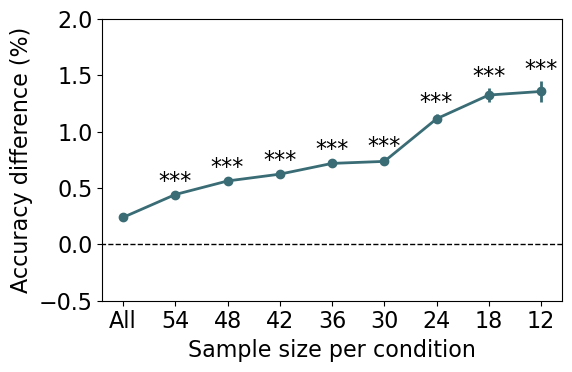

In [25]:
fig = plt.figure(figsize=(6, 4))

mean = [np.mean(a - b) for a, b in zip(accList_NRM_SVMlinear, accList_PCA_SVMlinear)]
se = [np.std(a - b) / np.sqrt(len(a)) for a, b in zip(accList_NRM_SVMlinear, accList_PCA_SVMlinear)]
plt.errorbar(range(len(mean)), mean, yerr=se, 
             marker="o", linewidth=2, color="#396C75")

for i, (p, y, y_) in enumerate(zip(accList_pval, mean, se)):
    text = ""
    if p < 0.001:
        text = "***"
    elif p < 0.01:
        text = "**"
    elif p < 0.05:
        text = "*"
        
    plt.text(i, y + y_, text, ha="center", va="bottom")

plt.hlines(0, -1, len(nListStr), color="k", linewidth=1, zorder=0, linestyle="dashed")
plt.xticks(range(len(nListStr)), nListStr)
plt.xlim(-0.4, len(accList_NRM_SVMlinear) - 1 + 0.4)
plt.xlabel("Sample size per condition")
plt.yticks(np.arange(-0.5, 2.1, 0.5))
plt.ylim(-0.5, 2)
plt.ylabel("Accuracy difference (%)")
plt.tight_layout()
plt.show()